#### Load Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, Dropout, Input, GlobalAveragePooling2D, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import os
import itertools
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

tf.config.list_physical_devices('gpu')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices("GPU"))

%matplotlib inline


2024-04-27 04:36:54.324661: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-27 04:36:54.348667: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 04:36:54.348691: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 04:36:54.349373: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-27 04:36:54.353422: I tensorflow/core/platform/cpu_feature_guar

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-27 04:36:55.609804: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-27 04:36:55.630933: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-27 04:36:55.631069: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

#### Set Path Variable

In [2]:
main_directory = '/home/dll-1/Desktop/eeg/datasets/Adil paper/scallogramTest3'

class_labels = ['normal', 'slowing-wave', 'spike-and-wave']
class_labels = ['Normal', 'Slowing Waves', 'Spike and Sharp waves']  # Names of subfolders with in main folder

dest_list = ['Normal', 'Slowing Waves', 'Spike and Sharp waves']  # Names of subfolders with in main folder
waveletsTypes = ['mexh','morl', 'gaus1', 'gaus2']
splits = ['train', 'valid', 'test']
import cv2
def crop_img(image):
    height, width = image.shape[:2]
    crop_height = height - 20  # Crop 10 pixels from top and bottom
    crop_width = width - 20    # Crop 10 pixels from left and right

    cropped_image = image[10:10+crop_height, 10:10+crop_width, :]
    cropped_image = cv2.resize(cropped_image,(224,224))
    return cropped_image

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = False)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = False)

test_datagen = ImageDataGenerator(rescale = 1./255)


#### Confusion Matrix

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [4]:
def plotImages(images_arr,train_labels):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    i=0
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(train_labels[i])
        i = i+1
    plt.tight_layout()
    plt.show()

# Model Implementation

### Prepare Callbacks

In [5]:
es = EarlyStopping(
    monitor = 'val_loss',
    patience = 2,
    verbose = 1,
    mode = 'auto'
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,mode = 'auto',
                              patience=2, min_lr=0.00001,verbose = 1)

os.chdir(main_directory)

## Google LeNEt

In [6]:
##### Google LeNet

###### Build Model

def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
    # Input: 
    # - f1: number of filters of the 1x1 convolutional layer in the first path
    # - f2_conv1, f2_conv3 are number of filters corresponding to the 1x1 and 3x3 convolutional layers in the second path
    # - f3_conv1, f3_conv5 are the number of filters corresponding to the 1x1 and 5x5  convolutional layer in the third path
    # - f4: number of filters of the 1x1 convolutional layer in the fourth path

    # 1st path:
    path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)

    # 2nd path
    path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)

    # 3rd path
    path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)

    # 4th path
    path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
    path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

    output_layer = concatenate([path1, path2, path3, path4], axis = -1)

    return output_layer

def GoogLeNet():
    tf.keras.backend.clear_session()
    # input layer 
    input_layer = Input(shape = (224, 224, 3))

    # convolutional layer: filters = 64, kernel_size = (7,7), strides = 2
    X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # convolutional layer: filters = 64, strides = 1
    X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)

    # convolutional layer: filters = 192, kernel_size = (3,3)
    X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 1st Inception block
    X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)

    # 2nd Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 3rd Inception block
    X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

    # Extra network 1:
    X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
    X1 = Flatten()(X1)
    X1 = Dense(1024, activation = 'relu')(X1)
    X1 = Dropout(0.7)(X1)
    X1 = Dense(3, activation = 'softmax')(X1)


    # 4th Inception block
    X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 5th Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)

    # 6th Inception block
    X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

    # Extra network 2:
    X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
    X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
    X2 = Flatten()(X2)
    X2 = Dense(1024, activation = 'relu')(X2)
    X2 = Dropout(0.7)(X2)
    X2 = Dense(3, activation = 'softmax')(X2)


    # 7th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, 
                      f3_conv5 = 128, f4 = 128)

    # max-pooling layer: pool_size = (3,3), strides = 2
    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # 8th Inception block
    X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)

    # 9th Inception block
    X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)

    # Global Average pooling layer 
    X = GlobalAveragePooling2D(name = 'GAPL')(X)

    # Dropoutlayer 
    X = Dropout(0.4)(X)

    # output layer 
    X = Dense(3, activation = 'softmax')(X)

    # model
    model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

    return model



## Vgg16

In [7]:
def plot_accuracy_loss(loss,val_loss,accuracy,val_accuracy):
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(accuracy)
    plt.plot(val_accuracy)
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [8]:
def test_model(model,test_batches,model_type):

    y_test=test_batches.classes

    model.evaluate(test_batches)

    predictions = model.predict(test_batches, verbose = 2)

    if model_type == "googlenet":
        y_pred = np.argmax(predictions[1], axis = 1)
    else:
        y_pred = np.argmax(predictions, axis = 1)    

    cm = confusion_matrix(y_test, y_pred)

    cm_plot_labels = ['Normal', 'Slowing Waves', 'Spike and Sharp Waves']
    plot_confusion_matrix(cm, cm_plot_labels, title = 'Confusion Matrix')

    print(accuracy_score(y_test, y_pred))

    target_names = ['Normal', 'Slowing Waves', 'Spike and Sharp Waves']
    print(classification_report(y_test, y_pred, target_names=target_names, digits=5))

In [9]:
def evaluate_googlenet(google_lenet, train_batches,valid_batches,checkpoint_filepath, class_weights):

    mc2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False)

    ###### Train Model
    history = google_lenet.fit(train_batches, validation_data = valid_batches ,callbacks=[es,mc2],epochs =30,shuffle = True)

    google_lenet.save(checkpoint_filepath+'/googlenet/GoogLenet_-final3.h5')
    google_lenet.save_weights(checkpoint_filepath+'/googlenet/GoogLenet_-final3.tf', save_format='tf')

    ###### Model Plots
    plot_accuracy_loss(history.history['dense_4_loss'],history.history['val_dense_4_loss'],history.history['dense_4_accuracy'],history.history['val_dense_4_accuracy'])

    return google_lenet


In [10]:
from sklearn.utils.class_weight import compute_class_weight
def evaluate_vgg16(vgg16_model_custom, train_batches,valid_batches,checkpoint_filepath, class_weights):
    ###### Train Model
    history = vgg16_model_custom.fit(x = train_batches, validation_data = valid_batches, callbacks = [es], epochs = 30, verbose = 1,shuffle = True)

    vgg16_model_custom.save(checkpoint_filepath+'/vgg16/VGG16_baseline3.h5')
    vgg16_model_custom.save_weights(checkpoint_filepath+'/vgg16/VGG16_baseline3.tf', save_format='tf')

    plot_accuracy_loss(history.history['loss'],history.history['val_loss'],history.history['accuracy'],history.history['val_accuracy'])

    return vgg16_model_custom

In [11]:
from sklearn.utils.class_weight import compute_class_weight
def evaluate_effNet(effNet_model_custom, train_batches,valid_batches,checkpoint_filepath, class_weights):
    ###### Train Model
    history = effNet_model_custom.fit(x = train_batches, validation_data = valid_batches, callbacks = [es], epochs = 30, verbose = 1,shuffle = True)

    effNet_model_custom.save(checkpoint_filepath+'/vgg16/effNet_baseline3.h5')
    effNet_model_custom.save_weights(checkpoint_filepath+'/vgg16/effNet_baseline3.tf', save_format='tf')

    plot_accuracy_loss(history.history['loss'],history.history['val_loss'],history.history['accuracy'],history.history['val_accuracy'])

    return effNet_model_custom

------------------- mexh -------------------------


Found 381190 images belonging to 3 classes.
Found 67267 images belonging to 3 classes.
Found 98965 images belonging to 3 classes.
Class Weights {0: 0.7025468914433368, 1: 1.0858257847661368, 2: 1.5252053599651099}


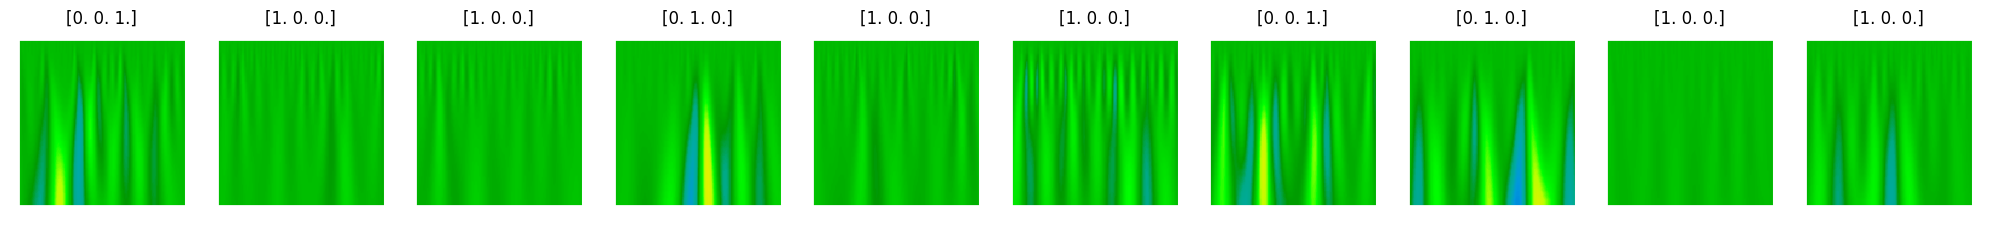

2024-04-27 04:36:58.857191: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-27 04:36:58.857336: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-27 04:36:58.857391: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

2024-04-27 04:37:12.003853: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inefficientnetb1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-04-27 04:37:13.755583: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-04-27 04:37:14.394767: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe72c6a8070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-27 04:37:14.394787: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-04-27 04:37:14.399820: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1714174634.455987 1281203 device_compiler.h:186] Compiled cluster

11913/11913 [==============================] - 1453s 120ms/step - loss: 0.9185 - accuracy: 0.6617 - val_loss: 0.8632 - val_accuracy: 0.6897
Epoch 2/30
11913/11913 [==============================] - 1403s 118ms/step - loss: 0.5280 - accuracy: 0.7890 - val_loss: 0.4747 - val_accuracy: 0.8119
Epoch 3/30
11913/11913 [==============================] - 1404s 118ms/step - loss: 0.4441 - accuracy: 0.8242 - val_loss: 0.3983 - val_accuracy: 0.8401
Epoch 4/30
11913/11913 [==============================] - 1401s 118ms/step - loss: 0.3986 - accuracy: 0.8423 - val_loss: 0.3874 - val_accuracy: 0.8430
Epoch 5/30
11913/11913 [==============================] - 1402s 118ms/step - loss: 0.3675 - accuracy: 0.8541 - val_loss: 0.3665 - val_accuracy: 0.8537
Epoch 6/30
11913/11913 [==============================] - 1404s 118ms/step - loss: 0.3393 - accuracy: 0.8664 - val_loss: 0.3720 - val_accuracy: 0.8527
Epoch 7/30
11913/11913 [==============================] - 1411s 118ms/step - loss: 0.3130 - accuracy: 0.8

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


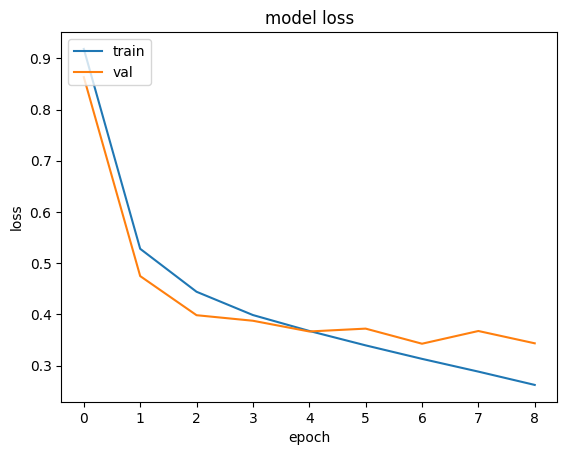

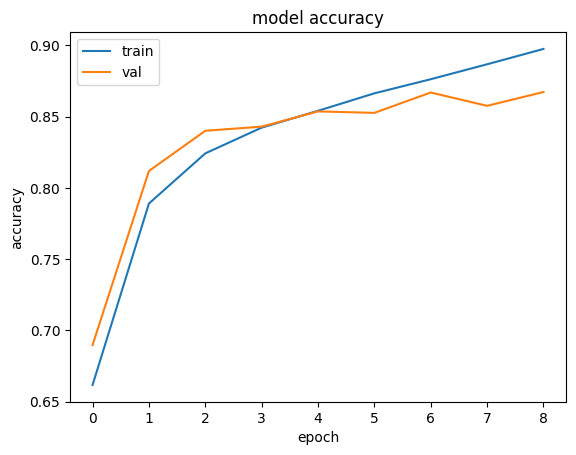

6186/6186 [==============================] - 101s 16ms/step - loss: 0.9783 - accuracy: 0.7118
6186/6186 - 87s - 87s/epoch - 14ms/step
Confusion matrix, without normalization
[[45501  3178  1961]
 [ 2301 12047 10816]
 [ 5592  4677 12892]]


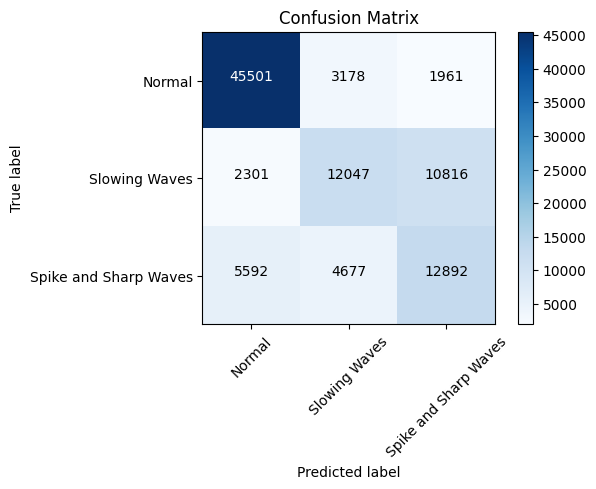

0.7117667862375587
                       precision    recall  f1-score   support

               Normal    0.85217   0.89852   0.87473     50640
        Slowing Waves    0.60532   0.47874   0.53464     25164
Spike and Sharp Waves    0.50224   0.55663   0.52804     23161

             accuracy                        0.71177     98965
            macro avg    0.65324   0.64463   0.64580     98965
         weighted avg    0.70751   0.71177   0.70712     98965

Epoch 1/30
11913/11913 [==============================] - 398s 32ms/step - loss: 1.7720 - dense_4_loss: 0.5795 - dense_1_loss: 0.6092 - dense_3_loss: 0.5833 - dense_4_accuracy: 0.7570 - dense_1_accuracy: 0.7410 - dense_3_accuracy: 0.7553 - val_loss: 1.6410 - val_dense_4_loss: 0.5439 - val_dense_1_loss: 0.5530 - val_dense_3_loss: 0.5441 - val_dense_4_accuracy: 0.7797 - val_dense_1_accuracy: 0.7744 - val_dense_3_accuracy: 0.7808
Epoch 2/30
11913/11913 [==============================] - 381s 32ms/step - loss: 1.4744 - dense_4_loss: 0.

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


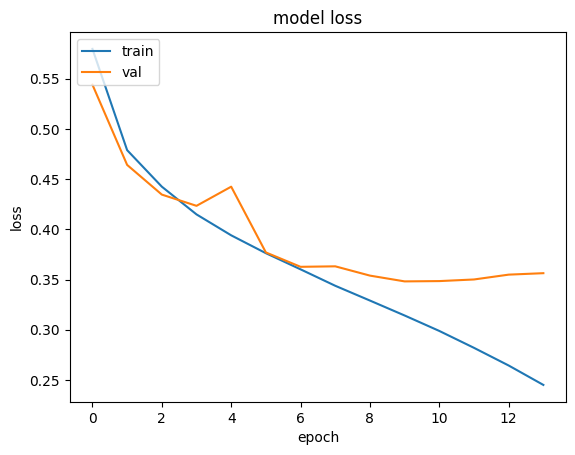

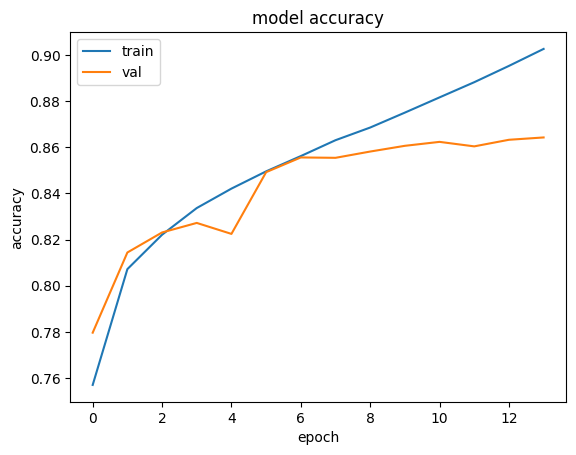

6186/6186 [==============================] - 65s 11ms/step - loss: 2.6961 - dense_4_loss: 0.9627 - dense_1_loss: 0.7937 - dense_3_loss: 0.9397 - dense_4_accuracy: 0.7141 - dense_1_accuracy: 0.7066 - dense_3_accuracy: 0.7074
6186/6186 - 61s - 61s/epoch - 10ms/step
Confusion matrix, without normalization
[[44917  3322  2401]
 [ 1979 12825 10360]
 [ 5104  5875 12182]]


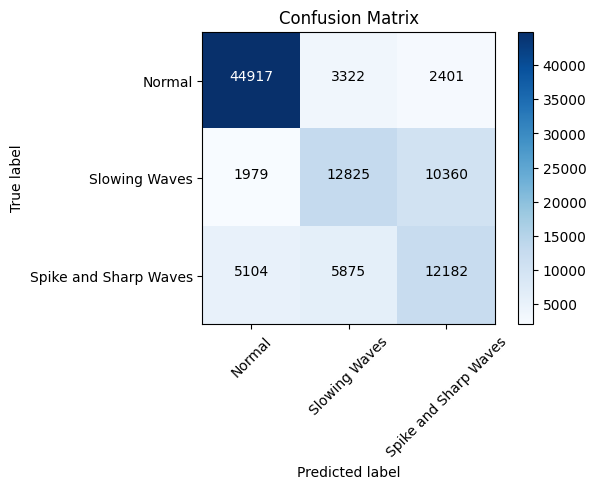

0.7065528217046431
                       precision    recall  f1-score   support

               Normal    0.86379   0.88699   0.87523     50640
        Slowing Waves    0.58237   0.50966   0.54359     25164
Spike and Sharp Waves    0.48839   0.52597   0.50649     23161

             accuracy                        0.70655     98965
            macro avg    0.64485   0.64087   0.64177     98965
         weighted avg    0.70438   0.70655   0.70461     98965

Epoch 1/30
11913/11913 [==============================] - 1387s 115ms/step - loss: 0.5086 - accuracy: 0.7945 - val_loss: 0.4624 - val_accuracy: 0.8157
Epoch 2/30
11913/11913 [==============================] - 1372s 115ms/step - loss: 0.4300 - accuracy: 0.8287 - val_loss: 0.5876 - val_accuracy: 0.8028
Epoch 3/30
11913/11913 [==============================] - 1371s 115ms/step - loss: 0.3953 - accuracy: 0.8424 - val_loss: 0.3814 - val_accuracy: 0.8503
Epoch 4/30
11913/11913 [==============================] - 1369s 115ms/step - loss: 0

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


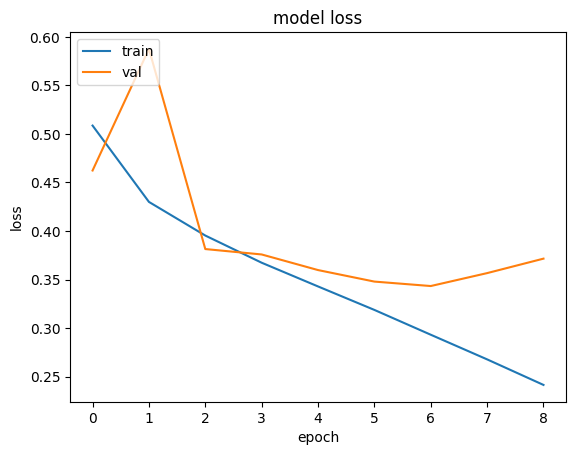

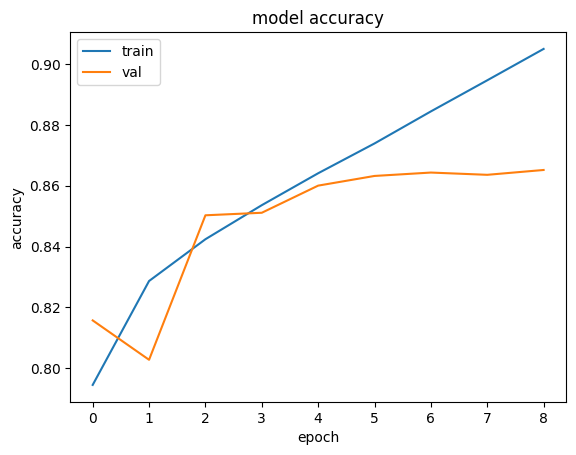

6186/6186 [==============================] - 137s 22ms/step - loss: 1.2486 - accuracy: 0.7011
6186/6186 - 129s - 129s/epoch - 21ms/step
Confusion matrix, without normalization
[[45670  2861  2109]
 [ 3651 11975  9538]
 [ 6283  5135 11743]]


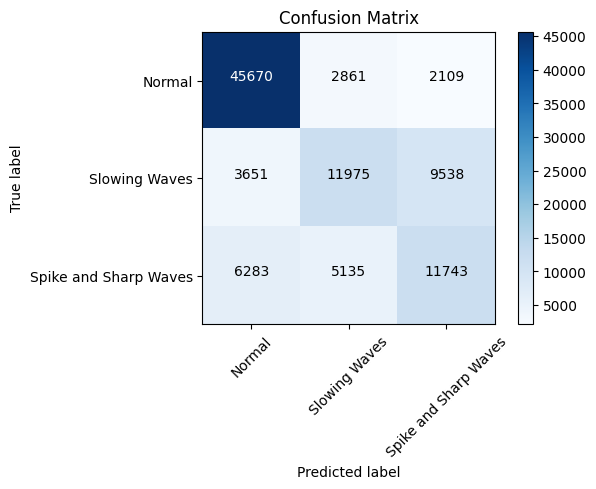

0.7011367655231647
                       precision    recall  f1-score   support

               Normal    0.82134   0.90186   0.85972     50640
        Slowing Waves    0.59962   0.47588   0.53063     25164
Spike and Sharp Waves    0.50205   0.50702   0.50452     23161

             accuracy                        0.70114     98965
            macro avg    0.64101   0.62825   0.63162     98965
         weighted avg    0.69024   0.70114   0.69291     98965

------------------- morl -------------------------
Found 381187 images belonging to 3 classes.
Found 67267 images belonging to 3 classes.
Found 99034 images belonging to 3 classes.
Class Weights {0: 0.702553015809825, 1: 1.0858172392183671, 2: 1.5251933564600864}


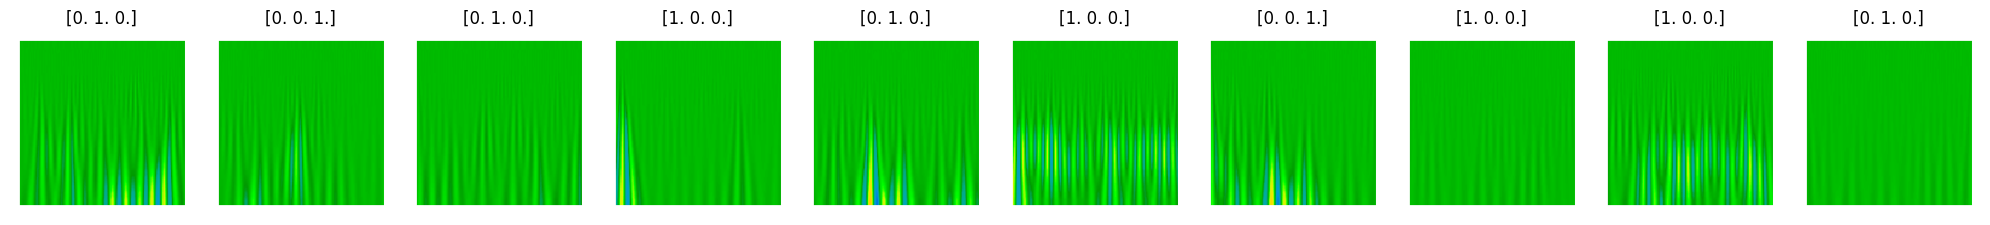

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

2024-04-27 13:14:01.157761: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inefficientnetb1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


11913/11913 [==============================] - 1443s 119ms/step - loss: 0.9764 - accuracy: 0.6074 - val_loss: 0.6947 - val_accuracy: 0.7046
Epoch 2/30
11913/11913 [==============================] - 1415s 119ms/step - loss: 0.6243 - accuracy: 0.7406 - val_loss: 0.5329 - val_accuracy: 0.7801
Epoch 3/30
11913/11913 [==============================] - 1414s 119ms/step - loss: 0.5238 - accuracy: 0.7869 - val_loss: 0.4788 - val_accuracy: 0.8045
Epoch 4/30
11913/11913 [==============================] - 1416s 119ms/step - loss: 0.4698 - accuracy: 0.8107 - val_loss: 0.4306 - val_accuracy: 0.8258
Epoch 5/30
11913/11913 [==============================] - 1416s 119ms/step - loss: 0.4309 - accuracy: 0.8270 - val_loss: 0.5907 - val_accuracy: 0.7624
Epoch 6/30
11913/11913 [==============================] - 1417s 119ms/step - loss: 0.4005 - accuracy: 0.8399 - val_loss: 0.4163 - val_accuracy: 0.8321
Epoch 7/30
11913/11913 [==============================] - 1418s 119ms/step - loss: 0.3695 - accuracy: 0.8

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


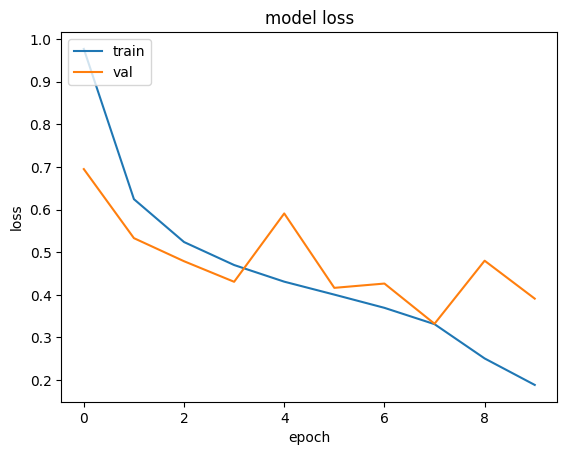

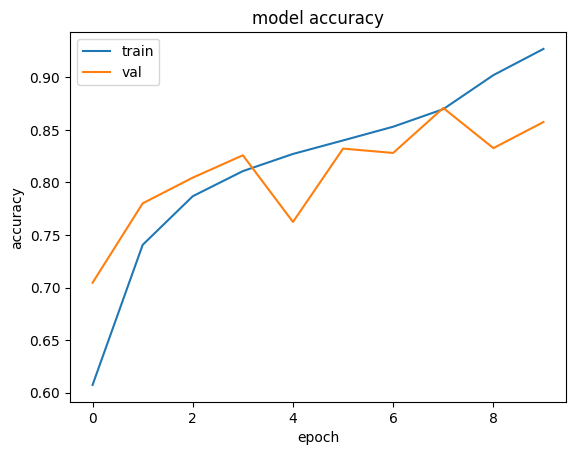

6190/6190 [==============================] - 104s 17ms/step - loss: 1.0454 - accuracy: 0.7096
6190/6190 - 89s - 89s/epoch - 14ms/step
Confusion matrix, without normalization
[[50291   126   292]
 [ 6209 10580  8375]
 [ 9592  4161  9408]]


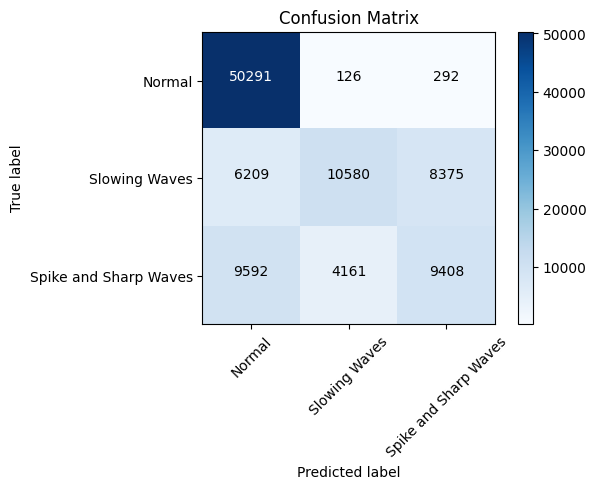

0.7096451723650463
                       precision    recall  f1-score   support

               Normal    0.76092   0.99176   0.86114     50709
        Slowing Waves    0.71164   0.42044   0.52859     25164
Spike and Sharp Waves    0.52050   0.40620   0.45630     23161

             accuracy                        0.70965     99034
            macro avg    0.66436   0.60613   0.61534     99034
         weighted avg    0.69217   0.70965   0.68196     99034

Epoch 1/30
11913/11913 [==============================] - 393s 32ms/step - loss: 1.9509 - dense_4_loss: 0.6430 - dense_1_loss: 0.6646 - dense_3_loss: 0.6433 - dense_4_accuracy: 0.7247 - dense_1_accuracy: 0.7136 - dense_3_accuracy: 0.7251 - val_loss: 1.6715 - val_dense_4_loss: 0.5554 - val_dense_1_loss: 0.5647 - val_dense_3_loss: 0.5514 - val_dense_4_accuracy: 0.7683 - val_dense_1_accuracy: 0.7652 - val_dense_3_accuracy: 0.7704
Epoch 2/30
11913/11913 [==============================] - 383s 32ms/step - loss: 1.5967 - dense_4_loss: 0.

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


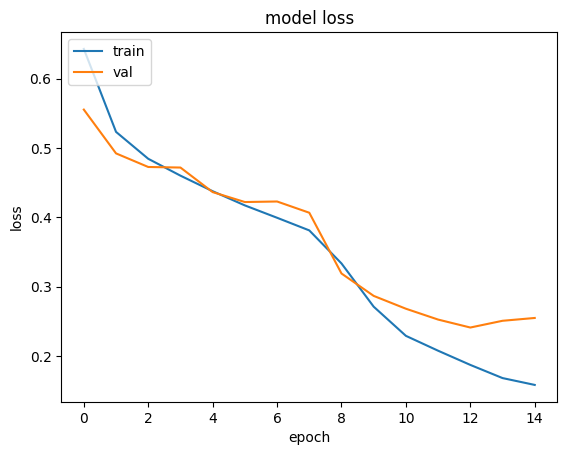

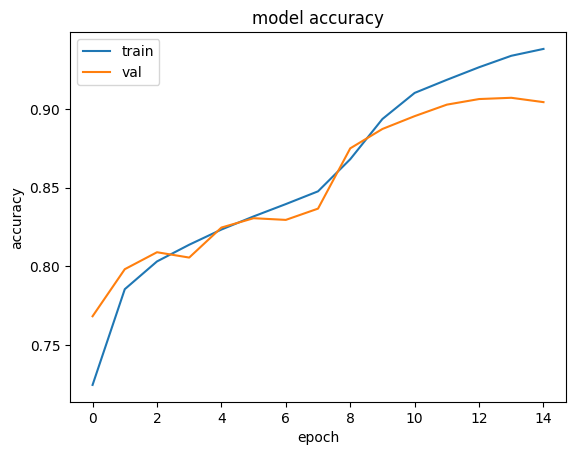

6190/6190 [==============================] - 65s 11ms/step - loss: 2.5552 - dense_4_loss: 0.9189 - dense_1_loss: 0.7314 - dense_3_loss: 0.9049 - dense_4_accuracy: 0.7266 - dense_1_accuracy: 0.7238 - dense_3_accuracy: 0.7257
6190/6190 - 62s - 62s/epoch - 10ms/step
Confusion matrix, without normalization
[[47995  1227  1487]
 [ 1075 11927 12162]
 [ 2806  8592 11763]]


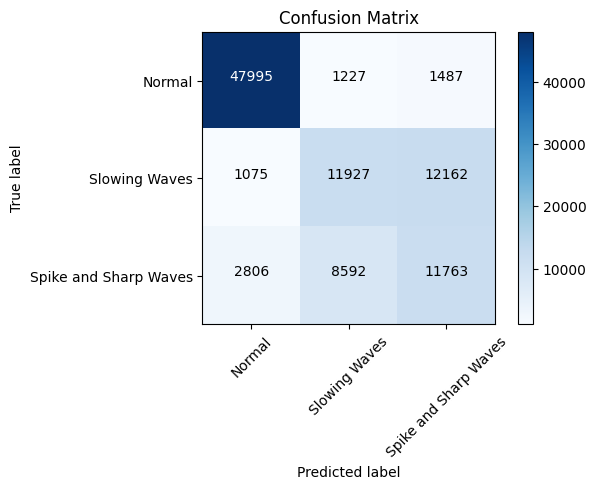

0.7238423167800957
                       precision    recall  f1-score   support

               Normal    0.92519   0.94648   0.93571     50709
        Slowing Waves    0.54847   0.47397   0.50851     25164
Spike and Sharp Waves    0.46289   0.50788   0.48434     23161

             accuracy                        0.72384     99034
            macro avg    0.64552   0.64278   0.64285     99034
         weighted avg    0.72135   0.72384   0.72160     99034

Epoch 1/30
11913/11913 [==============================] - 1384s 116ms/step - loss: 0.5685 - accuracy: 0.7639 - val_loss: 0.4811 - val_accuracy: 0.8028
Epoch 2/30
11913/11913 [==============================] - 1372s 115ms/step - loss: 0.4593 - accuracy: 0.8151 - val_loss: 0.4480 - val_accuracy: 0.8165
Epoch 3/30
11913/11913 [==============================] - 1369s 115ms/step - loss: 0.2794 - accuracy: 0.8890 - val_loss: 0.2487 - val_accuracy: 0.9005
Epoch 4/30
11913/11913 [==============================] - 1408s 118ms/step - loss: 0

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


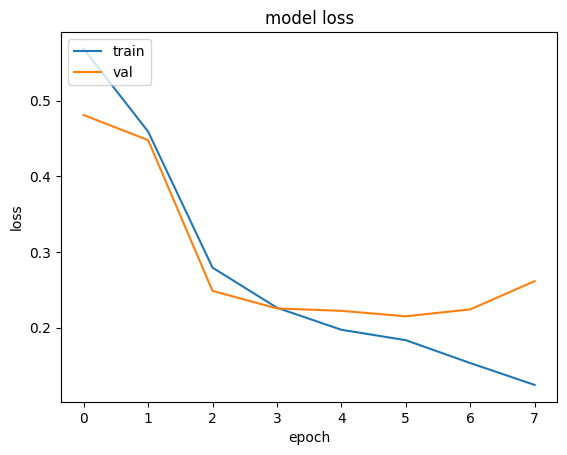

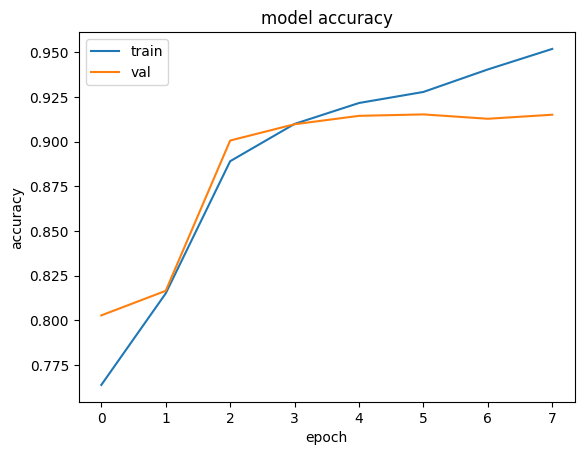

6190/6190 [==============================] - 142s 23ms/step - loss: 1.3699 - accuracy: 0.7479
6190/6190 - 151s - 151s/epoch - 24ms/step
Confusion matrix, without normalization
[[50015   258   436]
 [ 1296 11858 12010]
 [ 3323  7645 12193]]


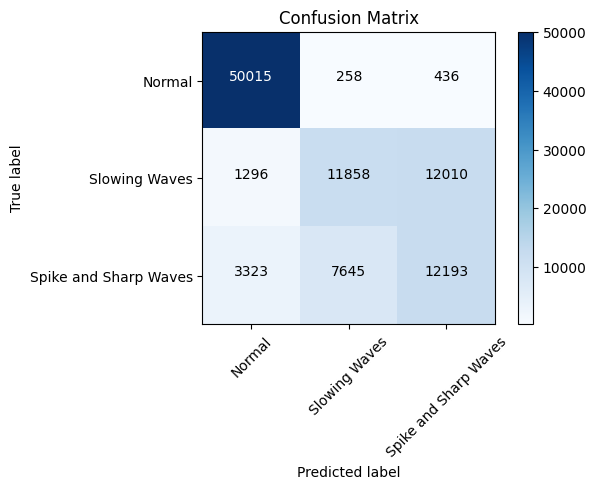

0.7478845648969041
                       precision    recall  f1-score   support

               Normal    0.91546   0.98631   0.94956     50709
        Slowing Waves    0.60007   0.47123   0.52790     25164
Spike and Sharp Waves    0.49487   0.52645   0.51017     23161

             accuracy                        0.74788     99034
            macro avg    0.67013   0.66133   0.66254     99034
         weighted avg    0.73696   0.74788   0.73966     99034

------------------- gaus1 -------------------------
Found 381132 images belonging to 3 classes.
Found 67257 images belonging to 3 classes.
Found 99022 images belonging to 3 classes.
Class Weights {0: 0.7026653318805551, 1: 1.085660570842591, 2: 1.5249732922013228}


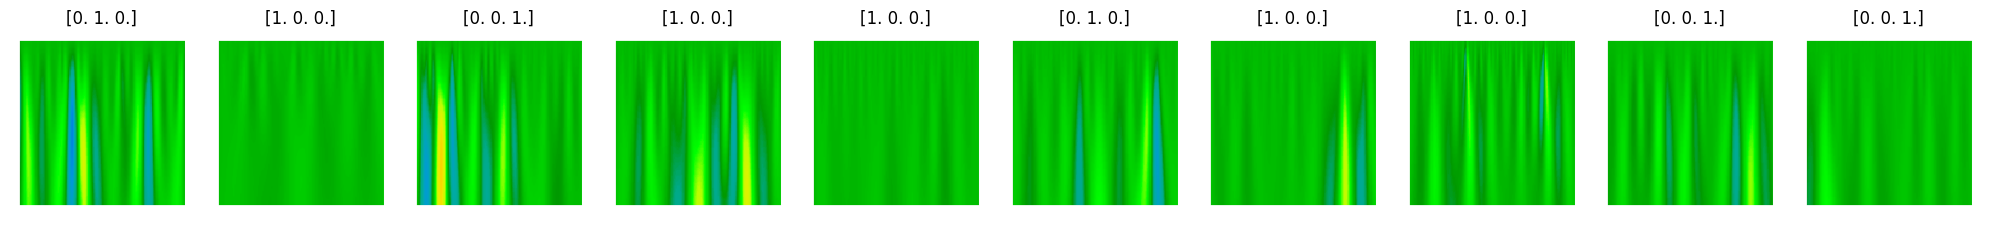

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

2024-04-27 22:00:09.503587: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inefficientnetb1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


11911/11911 [==============================] - 1482s 123ms/step - loss: 0.9278 - accuracy: 0.6520 - val_loss: 0.5817 - val_accuracy: 0.7533
Epoch 2/30
11911/11911 [==============================] - 1417s 119ms/step - loss: 0.5347 - accuracy: 0.7852 - val_loss: 0.4743 - val_accuracy: 0.8125
Epoch 3/30
11911/11911 [==============================] - 1417s 119ms/step - loss: 0.4421 - accuracy: 0.8240 - val_loss: 0.5220 - val_accuracy: 0.7883
Epoch 4/30
11911/11911 [==============================] - 1419s 119ms/step - loss: 0.3973 - accuracy: 0.8420 - val_loss: 0.3723 - val_accuracy: 0.8520
Epoch 5/30
11911/11911 [==============================] - 1419s 119ms/step - loss: 0.3665 - accuracy: 0.8539 - val_loss: 0.3853 - val_accuracy: 0.8450
Epoch 6/30
11911/11911 [==============================] - 1443s 121ms/step - loss: 0.3408 - accuracy: 0.8647 - val_loss: 0.3544 - val_accuracy: 0.8596
Epoch 7/30
11911/11911 [==============================] - 1420s 119ms/step - loss: 0.3166 - accuracy: 0.8

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


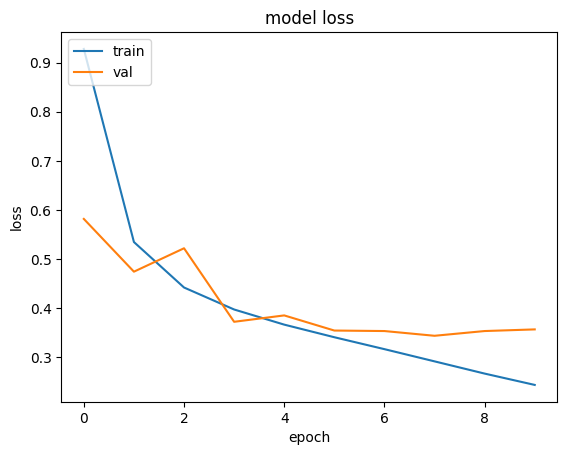

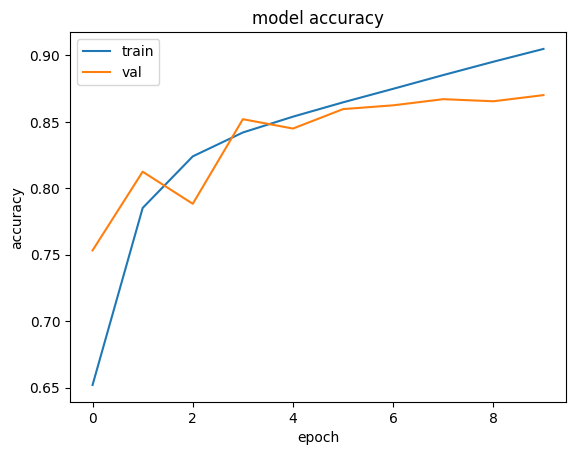

6189/6189 [==============================] - 96s 16ms/step - loss: 1.0365 - accuracy: 0.7037
6189/6189 - 86s - 86s/epoch - 14ms/step
Confusion matrix, without normalization
[[45554  3148  1995]
 [ 2908 12825  9431]
 [ 6167  5694 11300]]


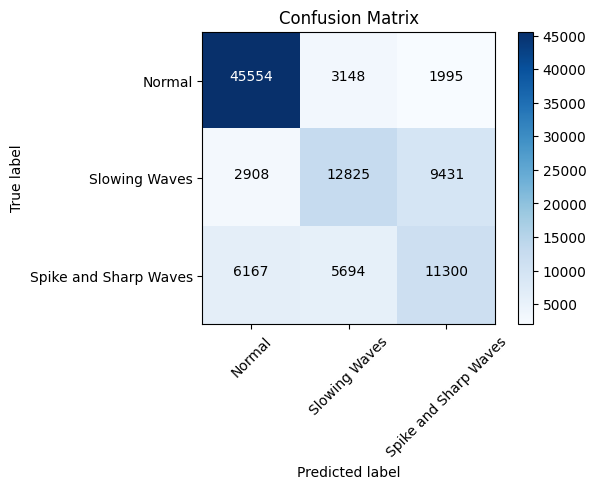

0.7036719112924401
                       precision    recall  f1-score   support

               Normal    0.83388   0.89855   0.86501     50697
        Slowing Waves    0.59191   0.50966   0.54771     25164
Spike and Sharp Waves    0.49723   0.48789   0.49251     23161

             accuracy                        0.70367     99022
            macro avg    0.64101   0.63203   0.63508     99022
         weighted avg    0.69365   0.70367   0.69725     99022

Epoch 1/30
11911/11911 [==============================] - 390s 32ms/step - loss: 1.7699 - dense_4_loss: 0.5797 - dense_1_loss: 0.6069 - dense_3_loss: 0.5834 - dense_4_accuracy: 0.7575 - dense_1_accuracy: 0.7436 - dense_3_accuracy: 0.7556 - val_loss: 1.5372 - val_dense_4_loss: 0.4985 - val_dense_1_loss: 0.5368 - val_dense_3_loss: 0.5018 - val_dense_4_accuracy: 0.7988 - val_dense_1_accuracy: 0.7812 - val_dense_3_accuracy: 0.7959
Epoch 2/30
11911/11911 [==============================] - 380s 32ms/step - loss: 1.4590 - dense_4_loss: 0.

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


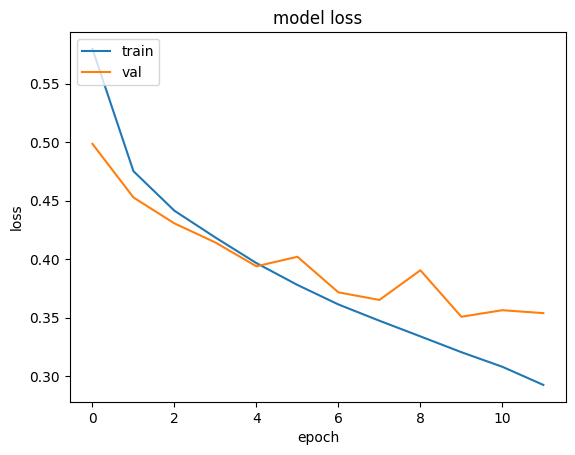

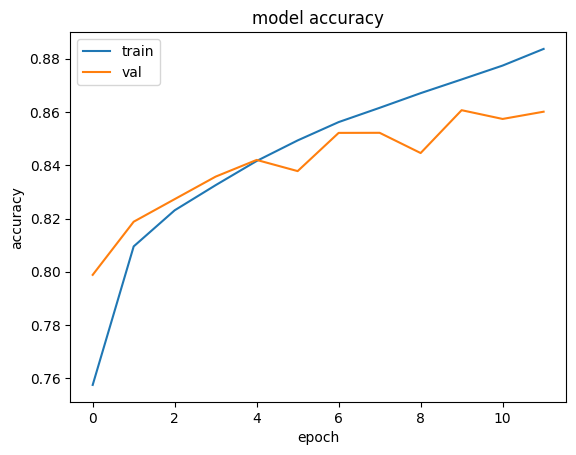

6189/6189 [==============================] - 63s 10ms/step - loss: 2.5807 - dense_4_loss: 0.8714 - dense_1_loss: 0.8218 - dense_3_loss: 0.8875 - dense_4_accuracy: 0.7173 - dense_1_accuracy: 0.7163 - dense_3_accuracy: 0.7144
6189/6189 - 60s - 60s/epoch - 10ms/step
Confusion matrix, without normalization
[[44722  2871  3104]
 [ 1969 11115 12080]
 [ 4403  3661 15097]]


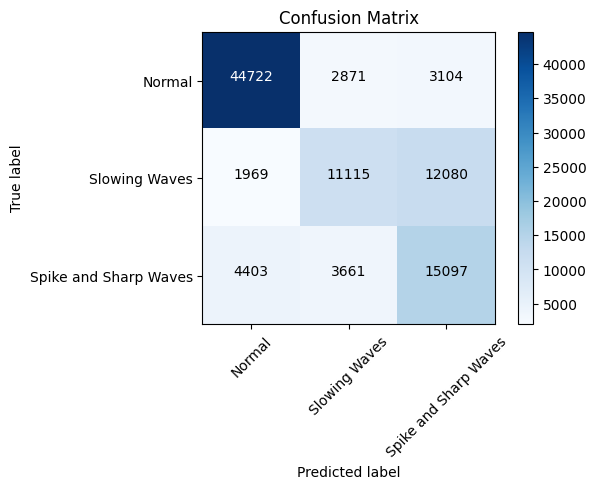

0.7163458625355982
                       precision    recall  f1-score   support

               Normal    0.87529   0.88214   0.87870     50697
        Slowing Waves    0.62985   0.44170   0.51926     25164
Spike and Sharp Waves    0.49856   0.65183   0.56499     23161

             accuracy                        0.71635     99022
            macro avg    0.66790   0.65856   0.65432     99022
         weighted avg    0.72480   0.71635   0.71398     99022

Epoch 1/30
11911/11911 [==============================] - 1385s 116ms/step - loss: 0.5112 - accuracy: 0.7929 - val_loss: 0.4451 - val_accuracy: 0.8240
Epoch 2/30
11911/11911 [==============================] - 1370s 115ms/step - loss: 0.4260 - accuracy: 0.8297 - val_loss: 0.4146 - val_accuracy: 0.8348
Epoch 3/30
11911/11911 [==============================] - 1367s 115ms/step - loss: 0.3941 - accuracy: 0.8425 - val_loss: 0.3969 - val_accuracy: 0.8415
Epoch 4/30
11911/11911 [==============================] - 1367s 115ms/step - loss: 0

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


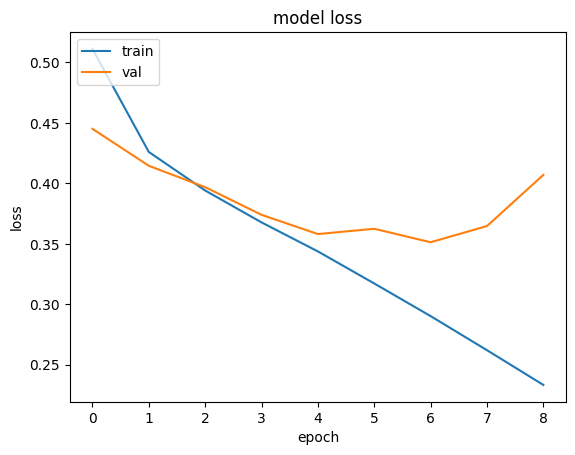

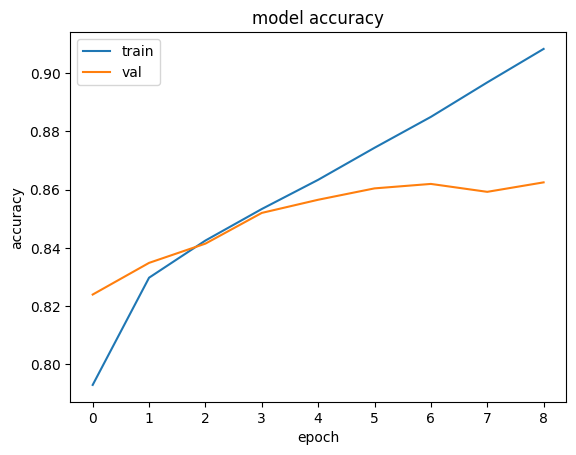

6189/6189 [==============================] - 138s 22ms/step - loss: 1.2000 - accuracy: 0.7174
6189/6189 - 129s - 129s/epoch - 21ms/step
Confusion matrix, without normalization
[[44924  3186  2587]
 [ 3163 12802  9199]
 [ 4879  4968 13314]]


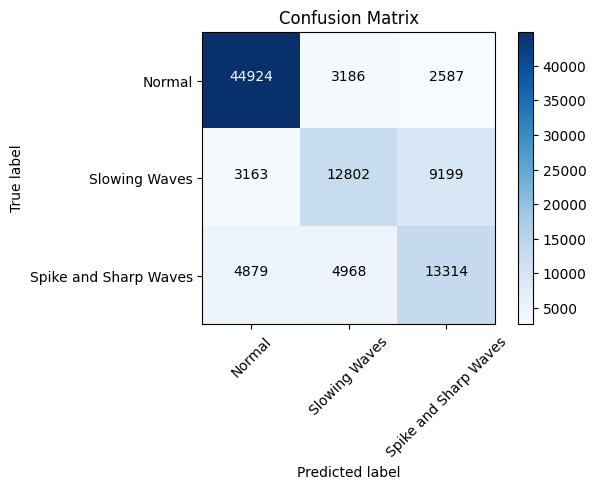

0.7174163317242633
                       precision    recall  f1-score   support

               Normal    0.84817   0.88613   0.86673     50697
        Slowing Waves    0.61090   0.50874   0.55516     25164
Spike and Sharp Waves    0.53044   0.57485   0.55175     23161

             accuracy                        0.71742     99022
            macro avg    0.66317   0.65657   0.65788     99022
         weighted avg    0.71356   0.71742   0.71388     99022

------------------- gaus2 -------------------------
Found 381221 images belonging to 3 classes.
Found 67272 images belonging to 3 classes.
Found 99031 images belonging to 3 classes.
Class Weights {0: 0.7024836182178685, 1: 1.0859140887597563, 2: 1.5253293961836856}


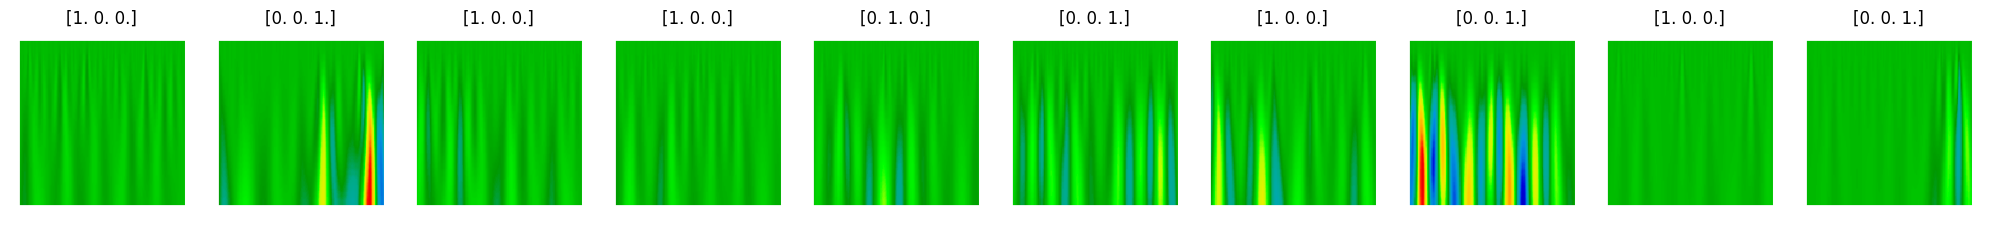

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

2024-04-28 06:49:24.040745: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inefficientnetb1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


11914/11914 [==============================] - 1441s 119ms/step - loss: 0.8642 - accuracy: 0.6735 - val_loss: 0.6586 - val_accuracy: 0.7403
Epoch 2/30
11914/11914 [==============================] - 1416s 119ms/step - loss: 0.5319 - accuracy: 0.7878 - val_loss: 0.4456 - val_accuracy: 0.8219
Epoch 3/30
11914/11914 [==============================] - 1419s 119ms/step - loss: 0.4482 - accuracy: 0.8230 - val_loss: 0.4446 - val_accuracy: 0.8234
Epoch 4/30
11914/11914 [==============================] - 1416s 119ms/step - loss: 0.4038 - accuracy: 0.8400 - val_loss: 0.4088 - val_accuracy: 0.8367
Epoch 5/30
11914/11914 [==============================] - 1417s 119ms/step - loss: 0.3701 - accuracy: 0.8531 - val_loss: 0.3635 - val_accuracy: 0.8552
Epoch 6/30
11914/11914 [==============================] - 1416s 119ms/step - loss: 0.3433 - accuracy: 0.8647 - val_loss: 0.3556 - val_accuracy: 0.8586
Epoch 7/30
11914/11914 [==============================] - 1417s 119ms/step - loss: 0.3179 - accuracy: 0.8

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


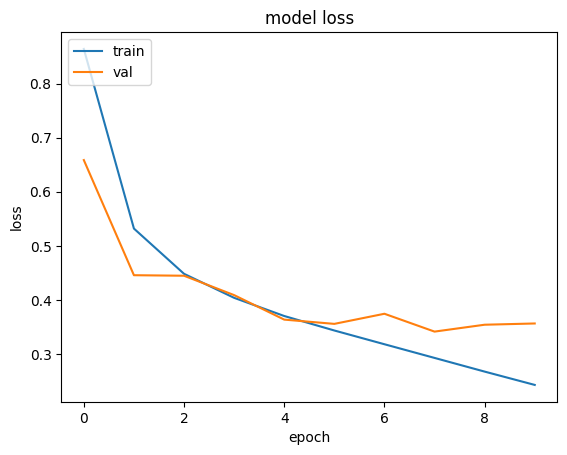

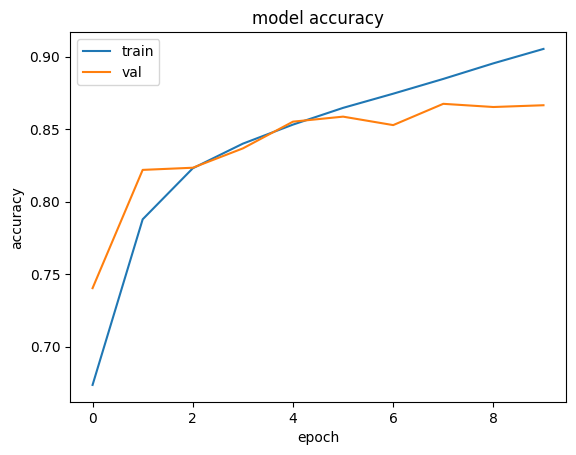

6190/6190 [==============================] - 99s 16ms/step - loss: 1.0136 - accuracy: 0.7034
6190/6190 - 85s - 85s/epoch - 14ms/step
Confusion matrix, without normalization
[[44110  3746  2850]
 [ 2172 13011  9981]
 [ 4533  6090 12538]]


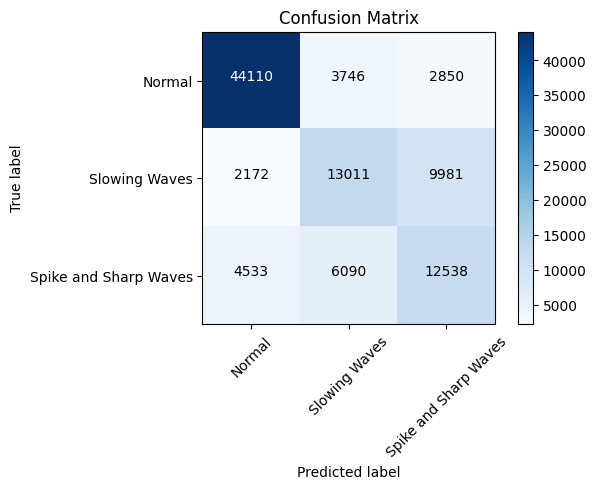

0.7034060041805091
                       precision    recall  f1-score   support

               Normal    0.86805   0.86992   0.86898     50706
        Slowing Waves    0.56948   0.51705   0.54200     25164
Spike and Sharp Waves    0.49423   0.54134   0.51671     23161

             accuracy                        0.70341     99031
            macro avg    0.64392   0.64277   0.64256     99031
         weighted avg    0.70476   0.70341   0.70351     99031

Epoch 1/30
11914/11914 [==============================] - 393s 32ms/step - loss: 1.7885 - dense_4_loss: 0.5860 - dense_1_loss: 0.6145 - dense_3_loss: 0.5880 - dense_4_accuracy: 0.7536 - dense_1_accuracy: 0.7374 - dense_3_accuracy: 0.7526 - val_loss: 1.5861 - val_dense_4_loss: 0.5203 - val_dense_1_loss: 0.5501 - val_dense_3_loss: 0.5157 - val_dense_4_accuracy: 0.7891 - val_dense_1_accuracy: 0.7734 - val_dense_3_accuracy: 0.7907
Epoch 2/30
11914/11914 [==============================] - 381s 32ms/step - loss: 1.4720 - dense_4_loss: 0.

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


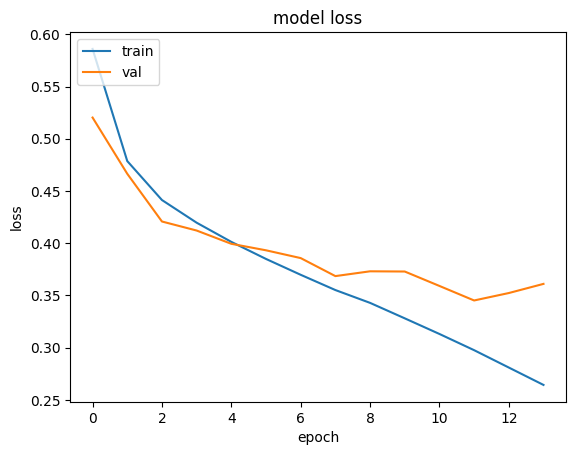

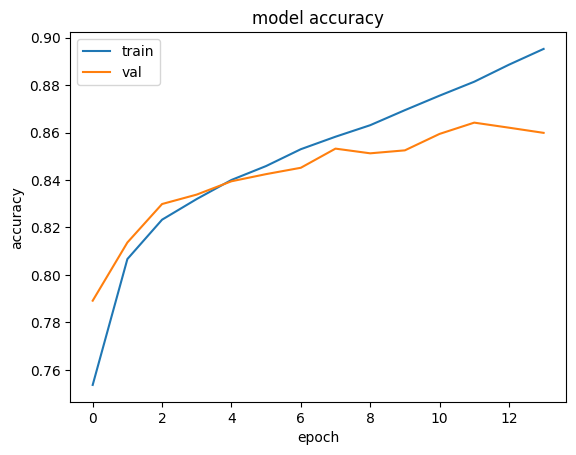

6190/6190 [==============================] - 64s 10ms/step - loss: 2.5956 - dense_4_loss: 0.9307 - dense_1_loss: 0.7714 - dense_3_loss: 0.8934 - dense_4_accuracy: 0.7222 - dense_1_accuracy: 0.7176 - dense_3_accuracy: 0.7235
6190/6190 - 62s - 62s/epoch - 10ms/step
Confusion matrix, without normalization
[[46067  2828  1811]
 [ 3933 12006  9225]
 [ 5778  4389 12994]]


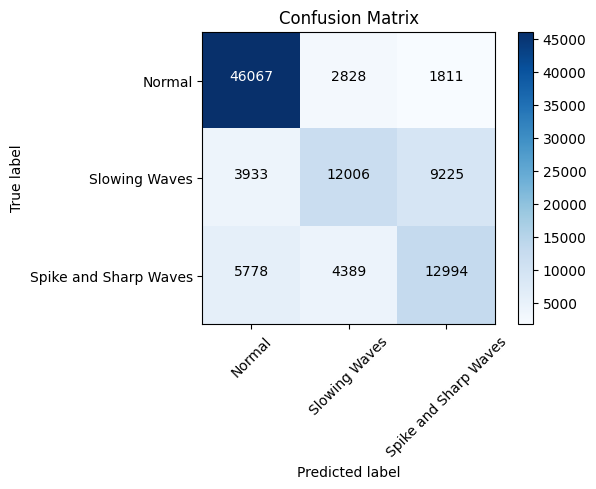

0.717623774373681
                       precision    recall  f1-score   support

               Normal    0.82590   0.90851   0.86524     50706
        Slowing Waves    0.62456   0.47711   0.54097     25164
Spike and Sharp Waves    0.54074   0.56103   0.55070     23161

             accuracy                        0.71762     99031
            macro avg    0.66373   0.64888   0.65230     99031
         weighted avg    0.70805   0.71762   0.70928     99031

Epoch 1/30
11914/11914 [==============================] - 1383s 116ms/step - loss: 0.5134 - accuracy: 0.7926 - val_loss: 0.4555 - val_accuracy: 0.8179
Epoch 2/30
11914/11914 [==============================] - 1371s 115ms/step - loss: 0.4272 - accuracy: 0.8300 - val_loss: 0.4048 - val_accuracy: 0.8381
Epoch 3/30
11914/11914 [==============================] - 1370s 115ms/step - loss: 0.3949 - accuracy: 0.8430 - val_loss: 0.3907 - val_accuracy: 0.8434
Epoch 4/30
11914/11914 [==============================] - 1367s 115ms/step - loss: 0.

/home/dll-1/Desktop/eeg/.conda/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


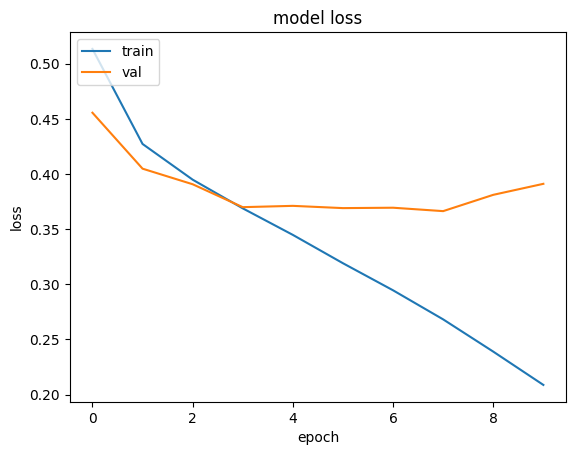

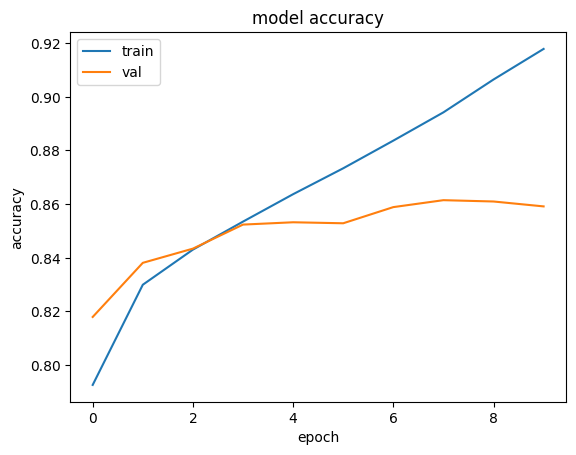

6190/6190 [==============================] - 139s 22ms/step - loss: 1.1418 - accuracy: 0.7061
6190/6190 - 130s - 130s/epoch - 21ms/step
Confusion matrix, without normalization
[[44761  3289  2656]
 [ 3949 11805  9410]
 [ 4993  4813 13355]]


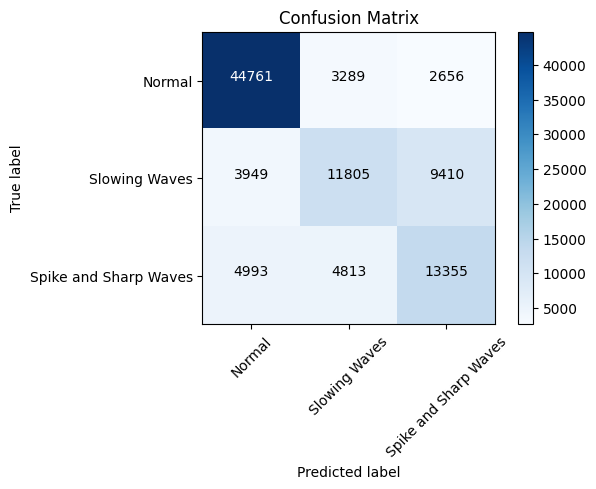

0.7060516403954318
                       precision    recall  f1-score   support

               Normal    0.83349   0.88276   0.85742     50706
        Slowing Waves    0.59301   0.46912   0.52384     25164
Spike and Sharp Waves    0.52535   0.57662   0.54979     23161

             accuracy                        0.70605     99031
            macro avg    0.65062   0.64283   0.64368     99031
         weighted avg    0.70032   0.70605   0.70071     99031



In [12]:
for waveletsType in waveletsTypes:
    
    print("-------------------",waveletsType,"-------------------------")
    checkpoint_filepath = '/home/dll-1/Desktop/eeg/datasets/models/adil/deeplearning/'+waveletsType

    train_path = main_directory +'/'+waveletsType+'/train' + '/'
    valid_path = main_directory +'/'+waveletsType+'/valid' + '/'
    test_path = main_directory +'/'+waveletsType+'/test' + '/'

    train_batches = train_datagen.flow_from_directory(directory = train_path, target_size = (224, 224),interpolation = 'nearest', classes = class_labels, batch_size = 32, shuffle = True)
    valid_batches = valid_datagen.flow_from_directory(directory = valid_path, target_size = (224, 224),interpolation = 'nearest', classes = class_labels, batch_size = 16)
    test_batches = test_datagen.flow_from_directory(directory = test_path, target_size = (224, 224), interpolation = 'nearest',classes = class_labels, batch_size = 16, shuffle = False)

    # Class Weigths
    labels = train_batches.classes
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
    class_weights = dict(enumerate(class_weights))
    print('Class Weights',class_weights)
    
    assert valid_batches.n > 0
    assert test_batches.n > 0
    assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 3

    imgs, train_labels = next(train_batches)
    plotImages(imgs,train_labels) 

    ##### VGG16

    ###### Import and Build Model

    vgg16_model = keras.applications.vgg16.VGG16()

    effNet_model_custom = tf.keras.applications.EfficientNetB1(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
    classes=3,classifier_activation='softmax')

    vgg16_model_custom = Sequential()
    for layer in vgg16_model.layers[:-1]:
        vgg16_model_custom.add(layer)

    # for layer in model.layers:
    #     layer.trainable = False

    vgg16_model_custom.add(Dense(3, activation = 'softmax'))

    vgg16_model_custom.summary()
    vgg16_model_custom.compile(Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    effNet_model_custom.summary()
    effNet_model_custom.compile(Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

    google_lenet = GoogLeNet()

    # google_lenet.summary()
    google_lenet.compile(optimizer = Adam(learning_rate = 0.0001), loss='categorical_crossentropy', metrics = ['accuracy'])

    effNet_model_custom = evaluate_vgg16(effNet_model_custom, train_batches,valid_batches,checkpoint_filepath, class_weights)
    test_model(effNet_model_custom, test_batches,"effNet")

    google_lenet_model = evaluate_googlenet(google_lenet, train_batches,valid_batches,checkpoint_filepath,class_weights)
    test_model(google_lenet,test_batches,"googlenet")
    
    vgg16_model_custom = evaluate_vgg16(vgg16_model_custom, train_batches,valid_batches,checkpoint_filepath, class_weights)
    test_model(vgg16_model_custom, test_batches,"vgg16")

    

    


    